# Building Neuron Tensors
Resources that have been useful:
* https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/
* https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
* https://cs231n.github.io/convolutional-networks/
* https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
* https://hackernoon.com/learning-keras-by-implementing-vgg16-from-scratch-d036733f2d5

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K

* load a pre-trained network (VGG16)
* input images from CIFAR-10 to VGG16
* choose some random unit in one of the layers and plot its activity for different images

## Load VGG16 model

In [3]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, weights='imagenet',input_shape=(32,32,3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [4]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

## Load CIFAR-10 Data

In [6]:
from tensorflow.python.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data() #load dataset into ~/.keras/datasets/

#printout shapes of train and test data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [7]:
N_train = 50000
N_test = 10000
img_shape = (32, 32, 3) #use a tuple in the fomat: (height, width, n_channels)
n_classes = 9
print(N_train,N_test,img_shape,n_classes)
y_train = tf.keras.utils.to_categorical(y_train,dtype='int')
y_test = tf.keras.utils.to_categorical(y_test,dtype='int')

50000 10000 (32, 32, 3) 9


In [9]:
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # note that layer.get_weights()[0] contains the weights and layer.get_weights()[0] the biases
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


### Define function for general layer/neuron/image index: 

outputSize_W = (W−F+2P)/S+1

outputSize_H = (H−F+2P)/S+1

W = width = 32, H = height = 32, F = filter size = 3, P = padding = 1, S = stride = 1

In [29]:
im = x_test[0]
im.shape

(32, 32, 3)

(32, 32)


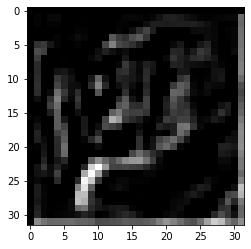

In [43]:
layer = model.layers[1] 
output_layer = K.function(inputs=[layer.input], 
                      outputs=[layer.output])
out = output_layer(np.array([im]))[0] 
out_feature_map_1 = out[0,:,:,0]
plt.imshow(out_feature_map_1, cmap='gray')
print(out_feature_map_1.shape)

In [49]:
out.shape

(1, 32, 32, 64)

In [53]:
_, nrow, ncol, n_feature_maps = out.shape[:]
n_feature_maps

64

(32, 32)


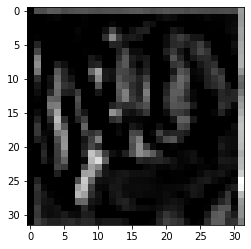

In [44]:
out_feature_map_64 = out[0,:,:,63]
plt.imshow(out_feature_map_64, cmap='gray')
print(out_feature_map_64.shape)

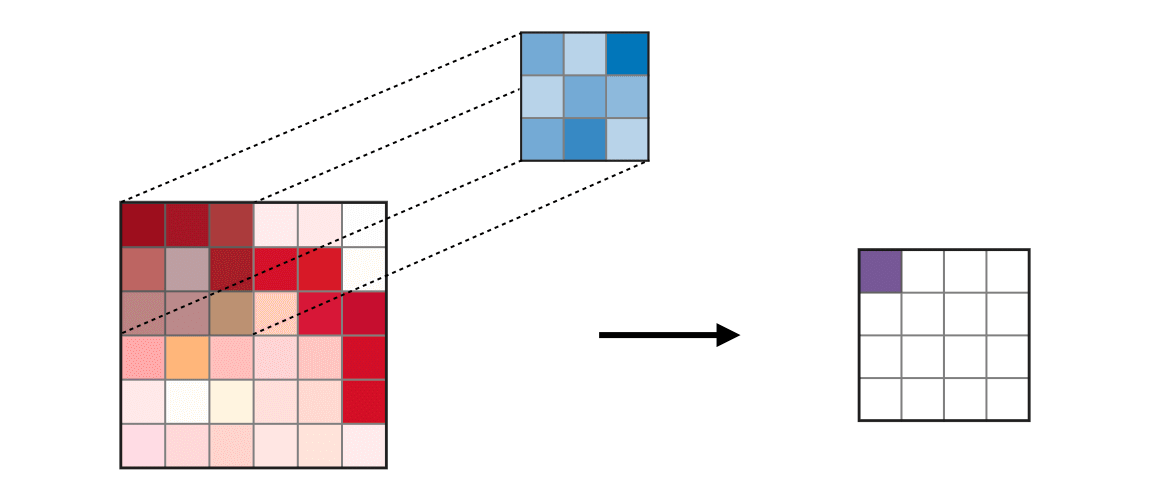

In [75]:
def compute_neuron_output(layer_index, image_index):
    
    layer = model.layers[layer_index] 
    output_layer = K.function(inputs=[layer.input], 
                          outputs=[layer.output])
    im = x_test[image_index]
    
    ## output is n feature maps
    out = output_layer(np.array([im]))[0] 
    
    ## number of neurons is nrow * ncol * n_feature_maps
    _, nrow, ncol, n_feature_maps = out.shape[:]
    
    out_all_neurons = []
    for i in range(n_feature_maps):
        out_all_neurons = np.hstack((out_all_neurons, out[0,:,:,i].flatten()))
    
    out_all_neurons = out_all_neurons.reshape((out_all_neurons.shape[0], 1))
    return out_all_neurons

In [76]:
out = compute_neuron_output(layer_index = 1, image_index = 0)
print(out)
out.shape
## output shape of the first layer = (None, 32, 32, 64) 
## number of neurons is 32*32*64 = 65536

[[  0.        ]
 [  0.        ]
 [  0.        ]
 ...
 [ 61.8705368 ]
 [ 70.64579773]
 [176.99209595]]


(65536, 1)

### Compute a matrix with output values for all neurons in layer 1 for test images 0:20

In [73]:
out_all_neurons_images = []
for i in range(20):
    if i == 0: 
        out_all_neurons_images = compute_neuron_output(layer_index = 1, image_index = 0)
    else:
        out_all_neurons_im = compute_neuron_output(layer_index = 1, image_index = i)
        out_all_neurons_images = np.hstack((out_all_neurons_images, out_all_neurons_im))
out_all_neurons_images.shape

(65536, 20)

In [80]:
print("Show the matrix with neuron outputs (neurons-by-images):")
print(out_all_neurons_images)

Show the matrix with neuron outputs (neurons-by-images):
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [ 61.8705368   43.1063652   36.7312088  ... 113.03523254  16.09518623
   72.29200745]
 [ 70.64579773  64.24550629   2.74592066 ... 102.52036285   0.
  115.80426788]
 [176.99209595 434.49865723  13.37190723 ... 463.0151062  169.31155396
  428.71096802]]


In [251]:
def apply_all_vertical_shifts(im):
    im_all_shifts = np.empty((32,32,32,3), dtype=int)
    im_vec = im.reshape(32*32,3)
    
    for i in range(32):
        im_shift = np.roll(im_vec,i*3*32)
        im_shift = im_shift.reshape((32,32,3))
        im_all_shifts[i] = im_shift
    return im_all_shifts

(32, 32, 32, 3)


Text(0.5, 0.98, 'Visualizing Vertical Shifts')

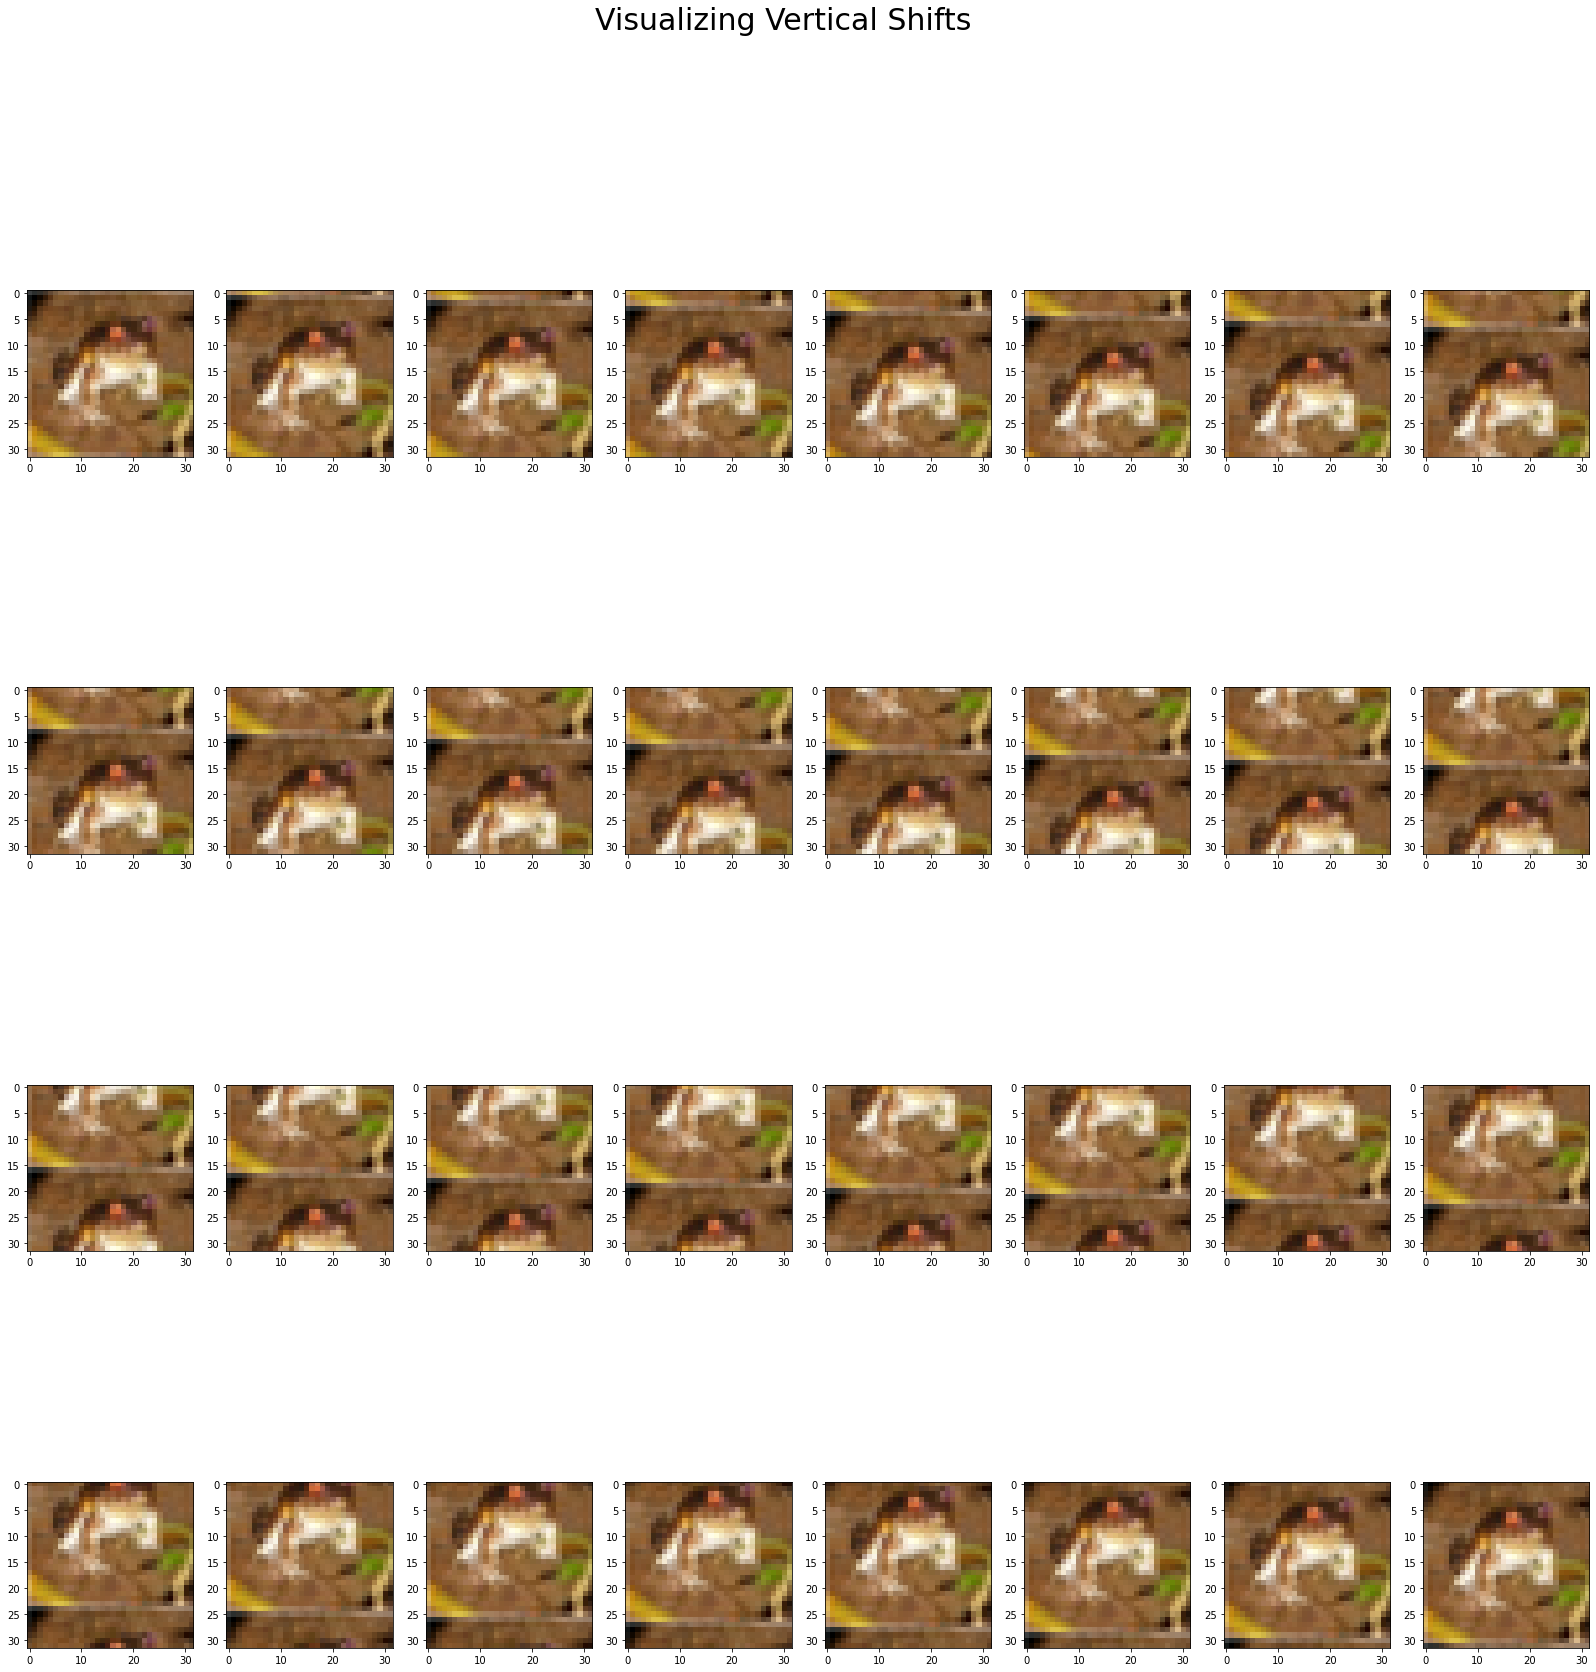

In [252]:
im_all_shifts = apply_all_vertical_shifts(im1)
print(im_all_shifts.shape)

fig, axs = plt.subplots(4,8, figsize = (28,28))
for i , ax in enumerate(axs.flatten()):
    ax.imshow(im_all_shifts[i,:,:,:])
fig.suptitle('Visualizing Vertical Shifts', fontsize=30)

### Applying horizontal shifts:
**note applying horizontal shifts is just transpose the image first, applying vertical shifts and then transpose back**

In [253]:
im1_T = np.transpose(im1, (1, 0, 2))

In [59]:
x_test.shape

(10000, 32, 32, 3)

(32, 32, 32, 3)


Text(0.5, 0.98, 'Visualizing Horizontal Shifts')

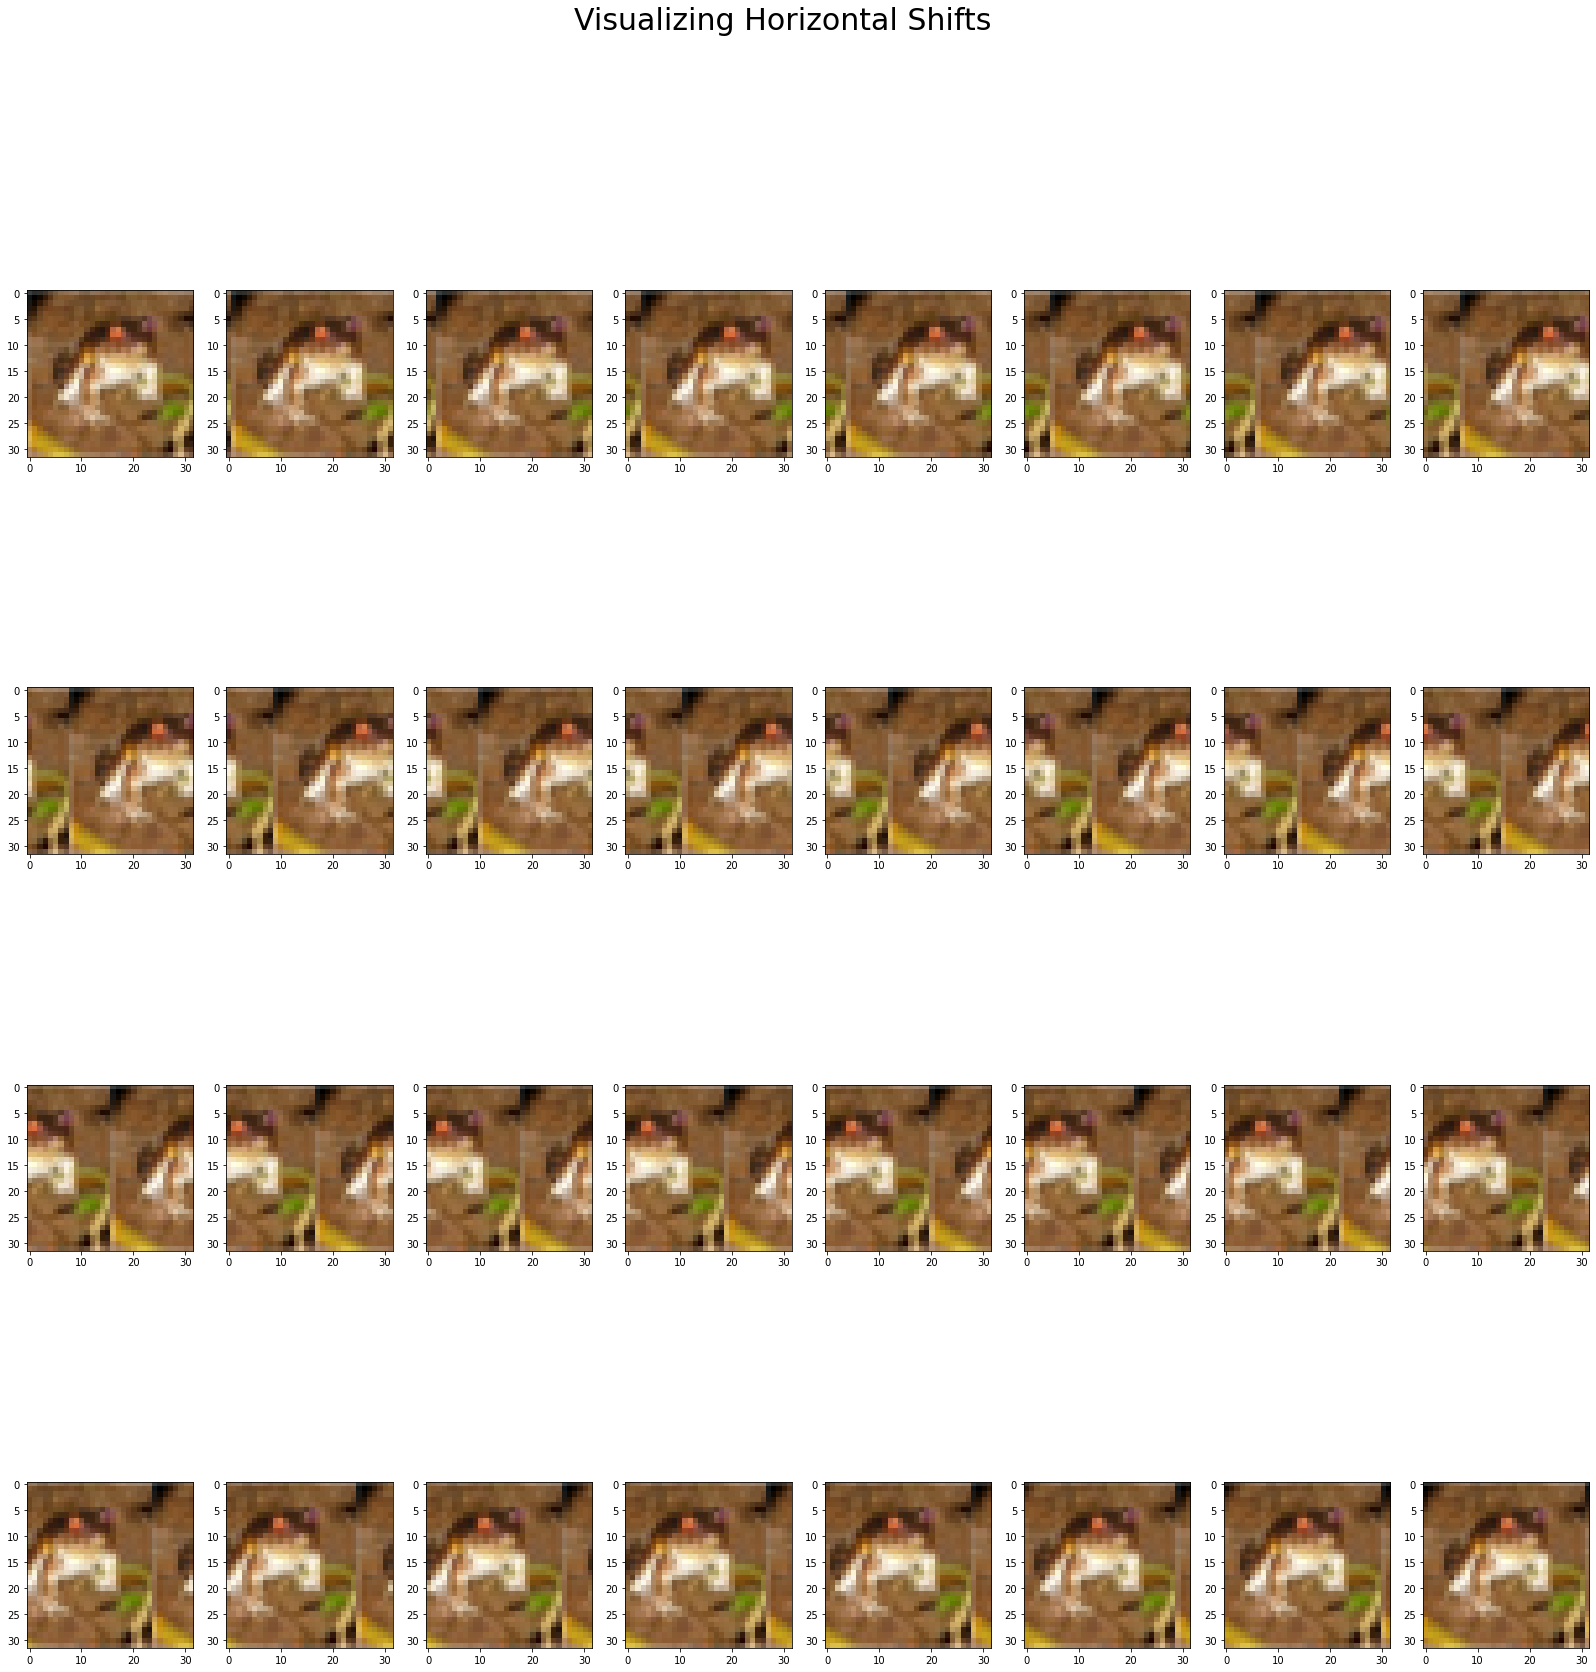

In [254]:
im_all_shifts_T = apply_all_vertical_shifts(im1_T)
print(im_all_shifts_T.shape)

fig, axs = plt.subplots(4,8, figsize = (28,28))
for i , ax in enumerate(axs.flatten()):
    im_all_shifts_T[i,:,:,:] = np.transpose(im_all_shifts_T[i,:,:,:], (1, 0, 2))
    ax.imshow(im_all_shifts_T[i,:,:,:])
fig.suptitle('Visualizing Horizontal Shifts', fontsize=30)